In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
if 'cvxopt' not in installedPackages :
    !pip install cvxopt==1.2.5

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

In [ ]:
# load dataset
dataset = read_csv('/content/crypto_data_cleaned.csv',index_col=0)

In [ ]:
dataset.shape

(1106, 13)

In [ ]:
dataset.head(5)

,_ADAUSDT_,_BTCUSDT_,_TRXUSDT_,_EOSUSDT_,_NEOUSDT_,_XLMUSDT_,_LINKUSDT_,_ZECUSDT_,_XRPUSDT_,_ETHUSDT_,_BNBUSDT_,_LTCUSDT_,_ETCUSDT_
Date,,,,,,,,,,,,,
30/03/2022,1.175,47102.00,0.06855,2.843,26.37,0.2302,16.73,191.0,0.8490,3360.22,430.2,128.4,49.18
29/03/2022,1.191,47434.80,0.06936,2.894,26.84,0.2331,16.98,196.3,0.8577,3400.51,434.2,130.1,49.28
28/03/2022,1.170,47122.21,0.06910,2.860,25.33,0.2298,16.50,192.2,0.8641,3332.92,430.2,127.6,47.07
27/03/2022,1.184,46827.76,0.06899,2.670,26.05,0.2297,16.87,210.3,0.8580,3295.65,430.5,129.7,48.00
26/03/2022,1.152,44511.27,0.06632,2.513,24.73,0.2157,15.83,204.8,0.8327,3145.00,415.8,124.8,47.18


In [ ]:
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = False


(1106, 13)

In [ ]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,_ADAUSDT_,_BTCUSDT_,_TRXUSDT_,_EOSUSDT_,_NEOUSDT_,_XLMUSDT_,_LINKUSDT_,_ZECUSDT_,_XRPUSDT_,_ETHUSDT_,_BNBUSDT_,_LTCUSDT_,_ETCUSDT_
Date,,,,,,,,,,,,,
30/03/2022,1.175,47102.0,0.06855,2.843,26.37,0.2302,16.73,191.0,0.8490,3360.22,430.2,128.4,49.18
29/03/2022,1.191,47434.8,0.06936,2.894,26.84,0.2331,16.98,196.3,0.8577,3400.51,434.2,130.1,49.28


In [ ]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [ ]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [ ]:
#Calculate percentage return for the training data set
returns = X_train.pct_change().dropna()

In [ ]:
#Question: Calculate percentage return for the test data set
returns_test=X_test.pct_change().dropna()

In [ ]:
# Question: compute a correlation-distance matrix by an correlation matrix
# Hint: you can find this equation in the HRP slides
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [ ]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 3.        , 11.        ,  0.38961034,  2.        ])

In [ ]:
# Question: try different distance measurements, such as complete, average. 
# More choices can be found: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

link_complete = linkage(dist, 'complete')
link_average = linkage(dist, 'average')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


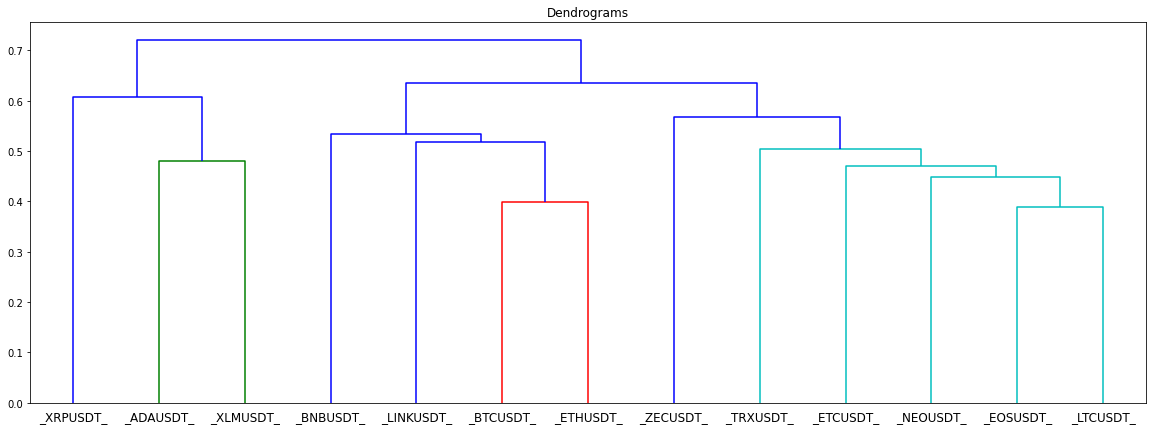

In [ ]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")
dendrogram(link,labels = X.columns)
plt.show()

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [ ]:
def getClusterVar(cov,cItems):
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    
    # Question: Compute variance per cluster: you can find this equation in the slides related to the recursive bisection
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [ ]:
# Question: Compute the inverse-variance portfolio: this equation can be found in the slides about recursive bisection
def getIVP(cov, **kargs): 
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [ ]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [ ]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    portfolios = pd.DataFrame([hrp], index=['HRP']).T
    return portfolios

In [ ]:
portfolios = get_all_portfolios(returns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'HRP')

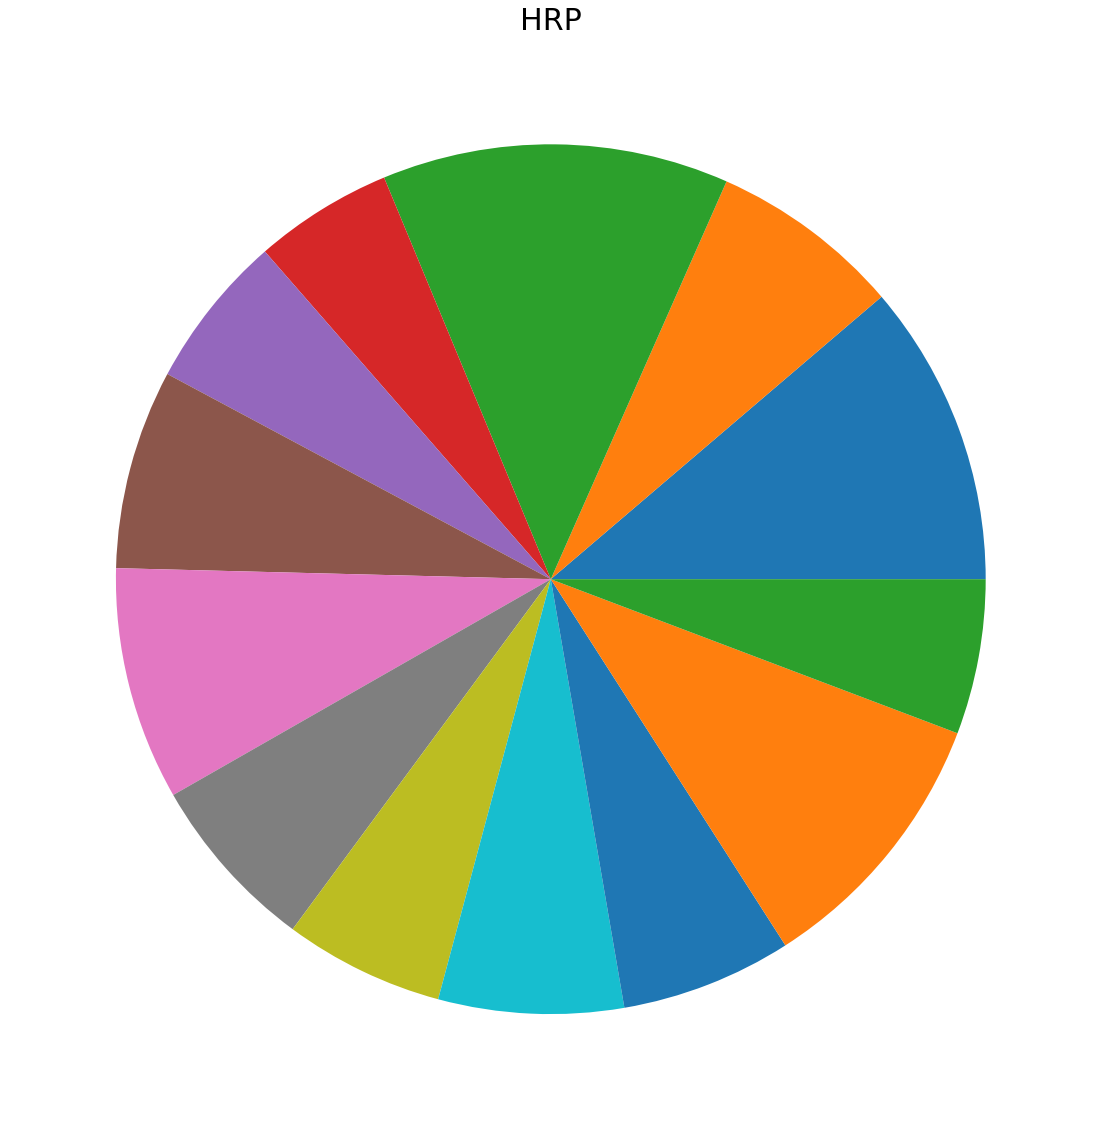

In [ ]:
fig, (ax1) = plt.subplots(1, 1,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0]);
ax1.set_title('HRP',fontsize = 30)

Back Testing 

In [ ]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['HRP'], index = returns_test.index)

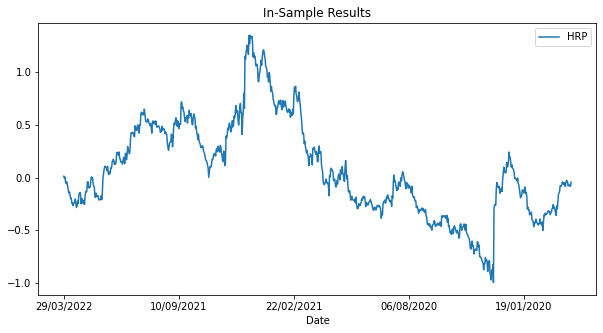

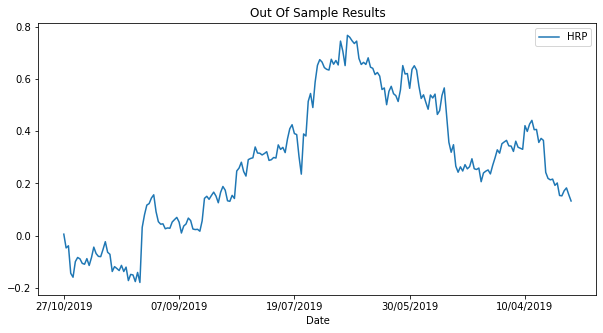

In [ ]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

In [ ]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
HRP,0.868781,-0.013943


In [ ]:
# Question: Inspired by the above in-sample process, please complete out-of-sample results.

stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
HRP,0.664735,0.227338
